In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe
from matplotlib.patches import FancyBboxPatch

from pypalettes import load_cmap
from highlight_text import ax_text, fig_text

from pyfonts import load_google_font

from drawarrow import ax_arrow

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geoplot
import geoplot.crs as gcrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from drawarrow import fig_arrow, ax_arrow

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Earthquake  dataset
eq_path = r"../data/eq_clean_m6_1900_2025.geojson"

# Data loading
eq = gpd.read_file(eq_path)

In [3]:
df = eq.copy()
df = df.sort_values(by="depth_km", ascending=False)

In [4]:
df["latitude"], df["longitude"] = df.geometry.y, df.geometry.x
df = df.drop(columns=["datetime_utc", "year", "month", "hour"])

In [ ]:
# Create sub-dataset of Pacific Rim region
lon = df["longitude"].values
lat = df["latitude"].values

# Pacific-facing longitudes (wraps across the dateline) + broad lat band
pacific_mask = ((lon >= 105) | (lon <= -70)) & (lat > -60) & (lat < 70)

df_rof  = df[pacific_mask].sort_values(by="depth_km", ascending=False)      # Ring of Fire
df_row = df[~pacific_mask].sort_values(by="depth_km", ascending=False)      # Everything else

eq_share_rof = (len(df_rof)/len(df))

In [ ]:
# CUSTOMIZATIONS

bg = "#222831"

map_color = "#393E46"
map_edge = "#EFEEEA"

bubble_color_row = '#98A1BC'
bubble_edgecolor_row = '#333446'

bubble_color_rof = '#FF9A00'
bubble_edgecolor_rof = "#3A0519"

text_col_h = "#FF9A00"
text_col_n = "#F8F4EC"

title_reg = load_google_font("Fjalla One")
title_b = load_google_font("Oswald", weight=600)
annot = load_google_font("PT Sans Narrow")
annot_b = load_google_font("PT Sans Narrow", weight=700)

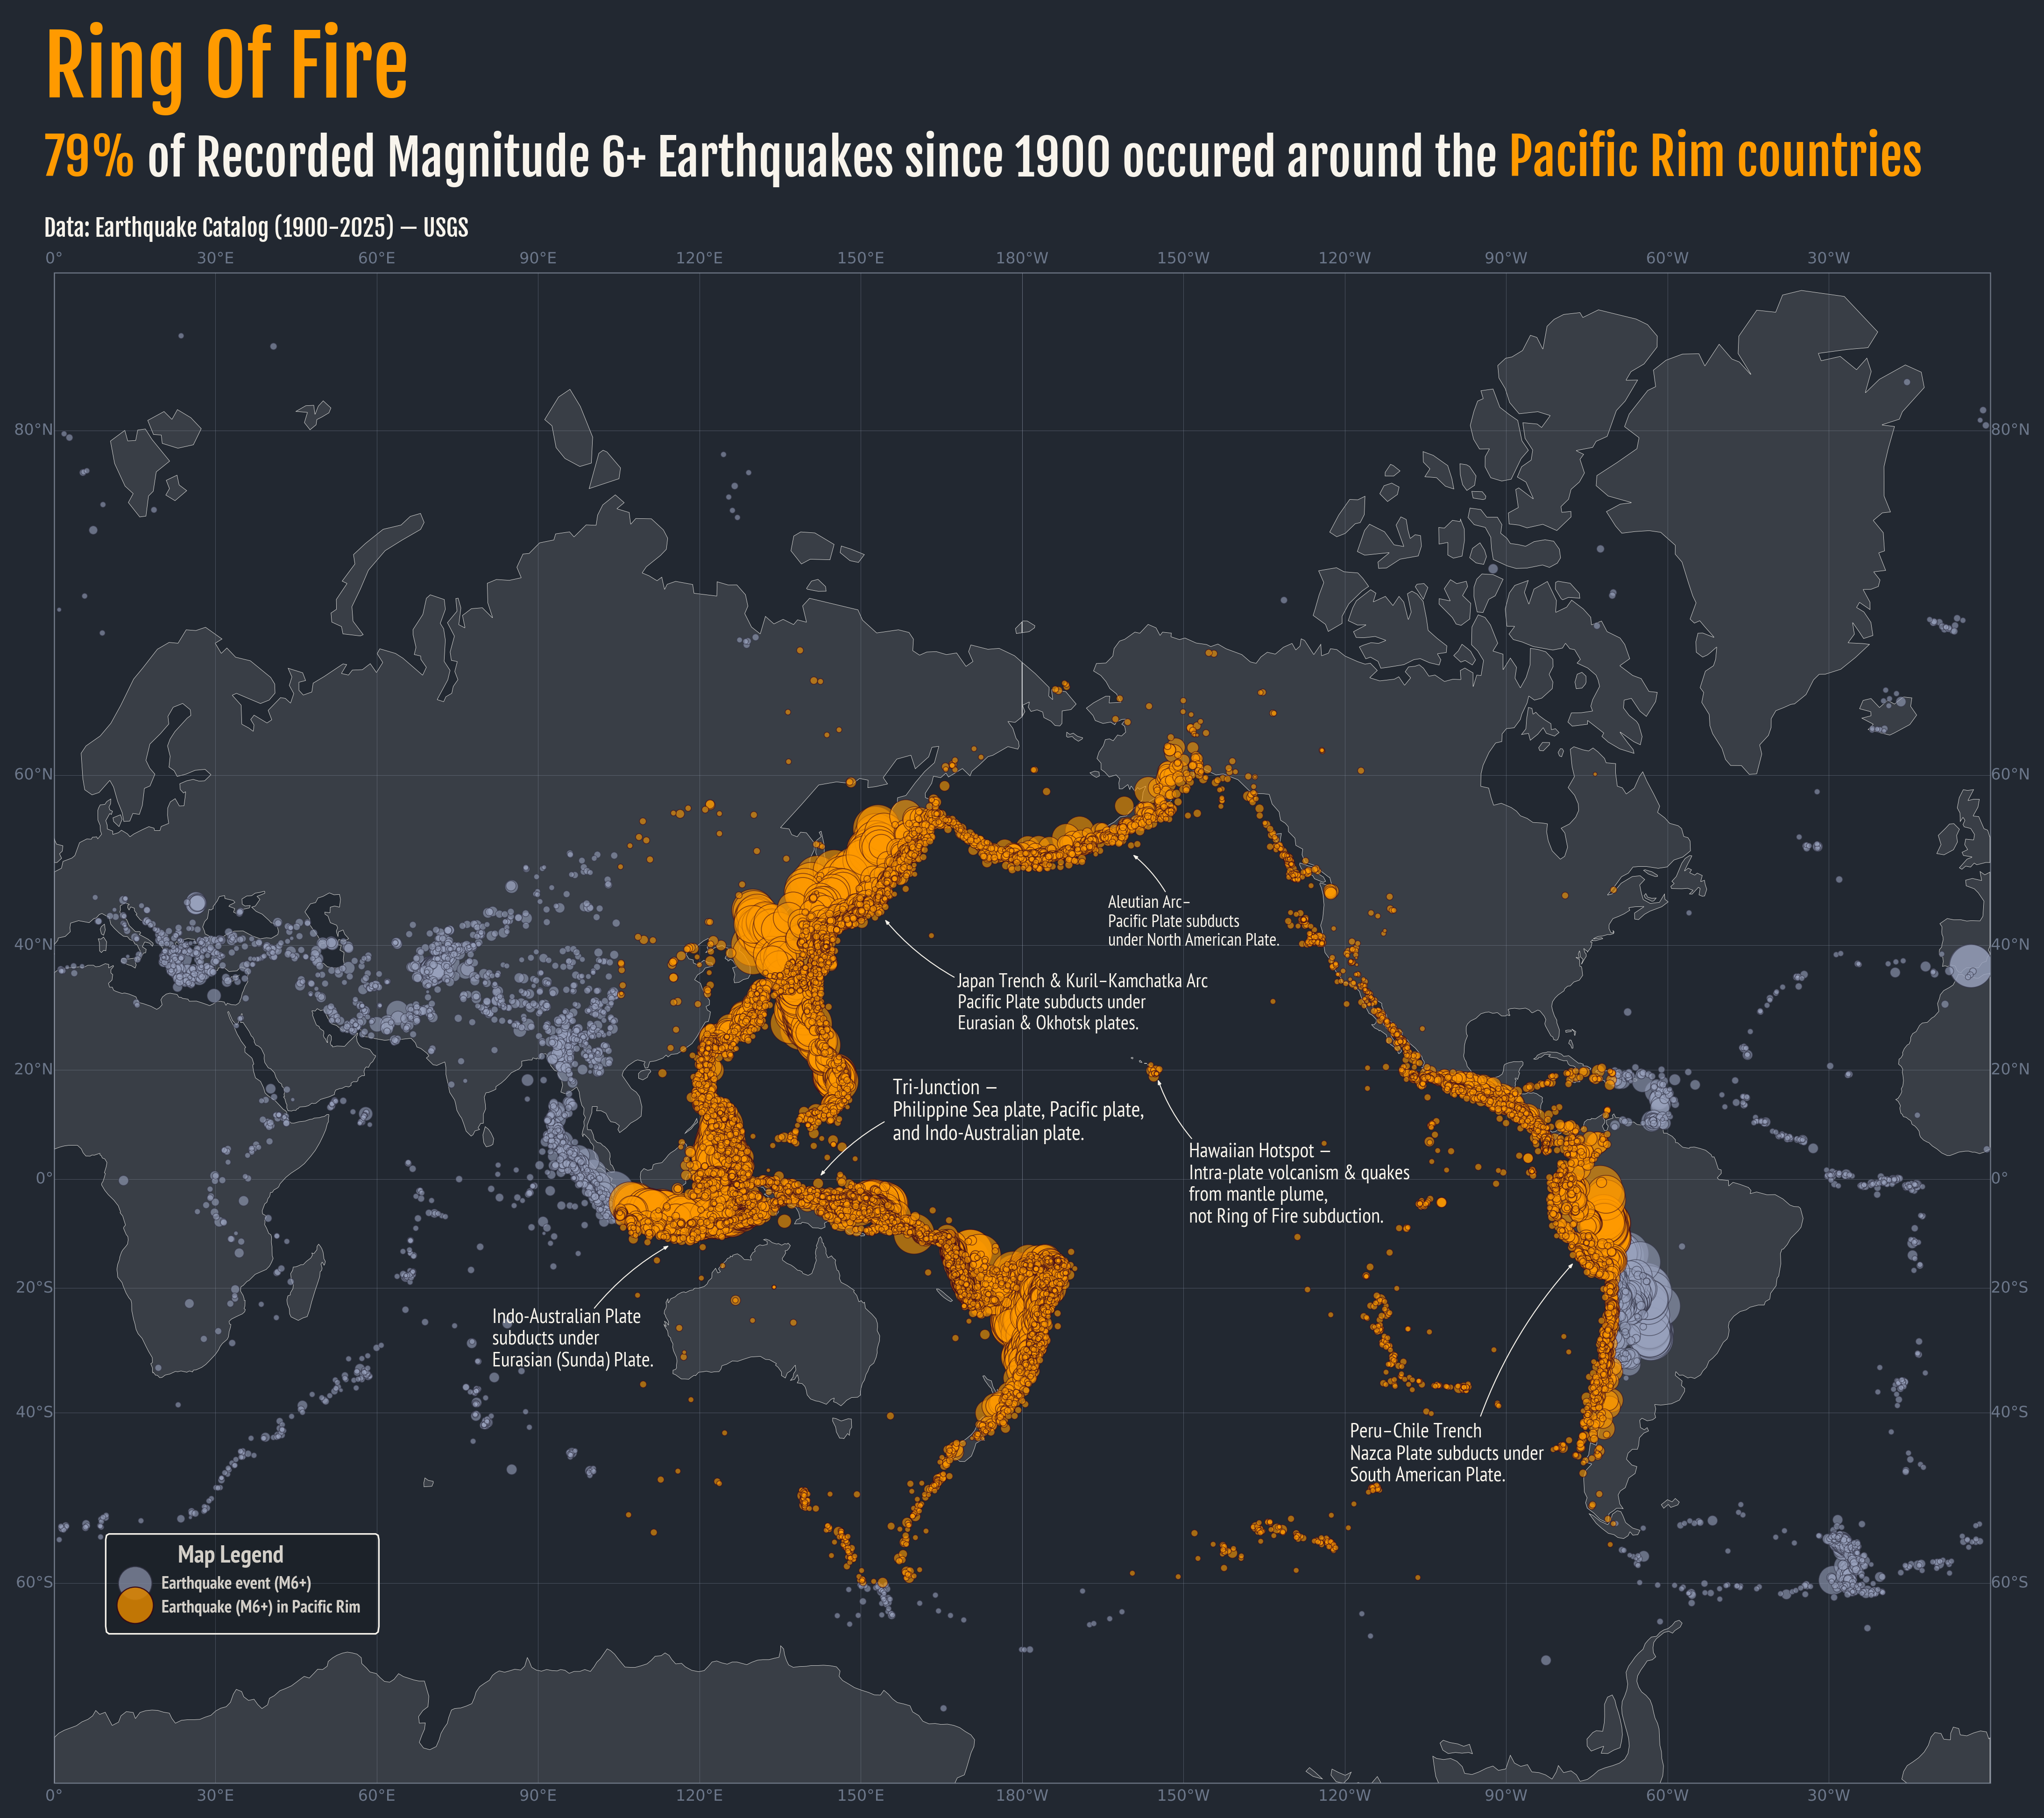

In [ ]:
# DATA VIZ BEGINS

# Change coordinate system to Mercator map projection
proj = ccrs.Mercator(central_longitude=180) # 180E as center line to keep Ring in focus

fig, ax = plt.subplots(figsize=(21,14), dpi=300, subplot_kw={'projection':proj})

# cleaning up the canvas
ax.set_axis_on()
geo_spine = ax.spines['geo']        
geo_spine.set_edgecolor('#9aa4b5')  
geo_spine.set_linewidth(0.6)
geo_spine.set_alpha(0.6)

# Add land boundaries
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor=map_color, edgecolor=map_edge, linewidth=0.4)
ax.add_feature(cfeature.OCEAN.with_scale('110m'), facecolor=bg)

# custom canvas color
fig.set_facecolor(bg)
ax.set_facecolor(bg)


# GRIDLINES for LATITUDE & LONGITUDE
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),          
    draw_labels=True,
    linewidth=0.25,                  
    color="#9aa4b5",                
    alpha=0.35,                      
    linestyle="-"
)


gl.top_labels = True
gl.right_labels = True
gl.bottom_labels = True
gl.left_labels = True

# Tick spacing
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.ylocator = mticker.FixedLocator(np.arange(-80,  81, 20))

# Label formatting (°E/°W, °N/°S)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Label style
label_style = {
    'size': 8,                       # font size
    'color': '#6c778a',              # label color
    'weight': 'medium',              # perceived thickness
    # optional stroke halo for readability on busy maps:
    'path_effects': [pe.withStroke(linewidth=1, foreground=bg)]
}
gl.xlabel_style = label_style
gl.ylabel_style = label_style

# Padding between labels and axes (px)
gl.xpadding = 3
gl.ypadding = 3



# transform the coordinates to the projection's CRS
pc = ccrs.PlateCarree()

# ROW EQs Bubble plot
new_coords_row = proj.transform_points(pc, df_row["longitude"].values, df_row["latitude"].values)
ax.scatter(
   new_coords_row[:, 0], new_coords_row[:, 1],
   s=df_row["depth_km"]*0.8, color=bubble_color_row,
   zorder=5, alpha=0.6, edgecolor=bubble_edgecolor_row, linewidth=0.4
)

# ROF EQs Bubble plot
new_coords_rof = proj.transform_points(pc, df_rof["longitude"].values, df_rof["latitude"].values)
ax.scatter(
   new_coords_rof[:, 0], new_coords_rof[:, 1],
   s=df_rof["depth_km"]*0.8, color=bubble_color_rof,
   zorder=10, alpha=0.6, edgecolor=bubble_edgecolor_rof, linewidth=0.4
)

# TITLE & ANNOTATIONS

title = "Ring Of Fire"
sub_title = f"<{eq_share_rof*100:.0f}%> of Recorded Magnitude 6+ Earthquakes since 1900 occured around the <Pacific Rim countries>"
data_cred = "Data: Earthquake Catalog (1900-2025) — USGS"

fig_text(s=title, x=0.18, y=1.008, size=42, color=text_col_h, font=title_reg)

fig_text(s=sub_title, x=0.18, y=0.9525, size=25.5, color=text_col_n, font=title_reg,
         highlight_textprops=[dict(color=text_col_h, size=26),
                              dict(color=text_col_h, size=26)])

fig_text(s=data_cred, x=0.18, y=0.91, size=12, color=text_col_n, font=title_reg)

# Triple Junction
ax_arrow(head_position=(142,0), tail_position=(155,11),
         transform=ccrs.PlateCarree()._as_mpl_transform(ax),
         radius=0.1, color=text_col_n, head_width=0.7, fill_head=True,
         width=0.5, head_length=2, zorder=10)
ax.text(
    s="Tri-Junction —\nPhilippine Sea plate, Pacific plate,\nand Indo-Australian plate.",
    x=156, y=7.4, color=text_col_n, fontproperties=annot,
    size=11, zorder=10, transform=ccrs.PlateCarree()
)

# Hawaiian Hotspot
ax_arrow(head_position=(-155,19), tail_position=(-148,7),
         transform=ccrs.PlateCarree()._as_mpl_transform(ax),
         radius=-0.1, color=text_col_n, head_width=0.7, fill_head=True,
         width=0.5, head_length=2, zorder=10)
ax.text(
    s="Hawaiian Hotspot —\nIntra-plate volcanism & quakes\nfrom mantle plume,\nnot Ring of Fire subduction.",
    x=-149, y=-8, color=text_col_n, fontproperties=annot,
    size=10.5, zorder=10, transform=ccrs.PlateCarree()
)

# Java/Sunda Trench
# Indo-Australian Plate subducts under Eurasian (Sunda) Plate → Sunda Arc volcanoes (Sumatra, Java, Bali)
# Lat/Long: ~10°S, 110°E (south of Java)
ax_arrow(head_position=(115,-12), tail_position=(100,-24),
         transform=ccrs.PlateCarree()._as_mpl_transform(ax),
         radius=-0.1, color=text_col_n, head_width=0.7, fill_head=True,
         width=0.5, head_length=2, zorder=10)
ax.text(
    s="Indo-Australian Plate\nsubducts under\nEurasian (Sunda) Plate.",
    x=81.5, y=-33, color=text_col_n, fontproperties=annot,
    size=10.5, zorder=10, transform=ccrs.PlateCarree()
)

# Peru–Chile Trench (Andes)
# Nazca Plate subducts under South American Plate → Andes uplift & mega-earthquakes
# 20°S, 72°W
ax_arrow(head_position=(-77,-15), tail_position=(-95,-41),
         transform=ccrs.PlateCarree()._as_mpl_transform(ax),
         radius=-0.1, color=text_col_n, head_width=0.7, fill_head=True,
         width=0.5, head_length=2, zorder=10)
ax.text(
    s="Peru–Chile Trench\nNazca Plate subducts under\nSouth American Plate.",
    x=-119, y=-49, color=text_col_n, fontproperties=annot,
    size=10.5, zorder=10, transform=ccrs.PlateCarree()
)

# Japan Trench & Kuril–Kamchatka Arc
# Pacific Plate subducts under Eurasian & Okhotsk plates → Deep quakes & volcanic arcs (Tohoku, Kuril, Kamchatka)
# 38°N, 142°E
ax_arrow(head_position=(154,44), tail_position=(168,35),
         transform=ccrs.PlateCarree()._as_mpl_transform(ax),
         radius=-0.1, color=text_col_n, head_width=0.7, fill_head=True,
         width=0.5, head_length=2, zorder=10)
ax.text(
    s="Japan Trench & Kuril–Kamchatka Arc\nPacific Plate subducts under\nEurasian & Okhotsk plates.",
    x=168, y=27, color=text_col_n, fontproperties=annot,
    size=10, zorder=10, transform=ccrs.PlateCarree()
)

# Aleutian Arc (Alaska)
# Pacific Plate subducts under North American Plate → Aleutian trench & volcanic island arc
# 52°N, 170°W
ax_arrow(head_position=(-160,52), tail_position=(-153,46.8),
         transform=ccrs.PlateCarree()._as_mpl_transform(ax),
         radius=0.1, color=text_col_n, head_width=0.7, fill_head=True,
         width=0.5, head_length=2, zorder=10)
ax.text(
    s="Aleutian Arc–\nPacific Plate subducts\nunder North American Plate.",
    x=-164, y=40, color=text_col_n, fontproperties=annot,
    size=9, zorder=10, transform=ccrs.PlateCarree()
)

# LEGEND

ax.text(
    s="Map Legend",
    x=23, y=-58, color=text_col_n, fontproperties=annot_b,
    size=12.5, zorder=12, transform=ccrs.PlateCarree()
)

# Rest of World
x_row, y_row = proj.transform_point(15, -60, pc)

ax.scatter(
    x_row, y_row,
    s=300,
    color=bubble_color_row, alpha=0.8,
    edgecolor=bubble_edgecolor_row, linewidth=0.6,
    zorder=12
)
ax.text(
    s="Earthquake event (M6+)",
    x=20, y=-60.5, color=text_col_n, fontproperties=annot_b,
    size=9, zorder=12, transform=ccrs.PlateCarree()
)

# Ring Of Fire
x_rof, y_rof = proj.transform_point(15, -62, pc)

ax.scatter(
    x_rof, y_rof,
    s=350,
    color=bubble_color_rof, alpha=0.88,
    edgecolor=bubble_edgecolor_rof, linewidth=0.6,
    zorder=12
)
ax.text(
    s="Earthquake (M6+) in Pacific Rim",
    x=20, y=-62.6, color=text_col_n, fontproperties=annot_b,
    size=9, zorder=12, transform=ccrs.PlateCarree()
)

# Box around the legend

box_lon, box_lat = 10, -64 # bottom-left corner of box in lon/lat degrees
box_w, box_h   = 50, 8.5   # box width & height

legend_box = FancyBboxPatch(
    (box_lon, box_lat), box_w, box_h,
    boxstyle="round, pad=0.4, rounding_size=0.6",
    linewidth=0.8, edgecolor=text_col_n,
    facecolor=(0, 0, 0, 0.15),  
    transform=ccrs.PlateCarree(),  
    zorder=12, clip_on=False
)
ax.add_patch(legend_box)

plt.savefig(r"../viz/ring_of_fire.jpeg", dpi=300, bbox_inches="tight", pad_inches=0.5)


---